# DSCI 632 Final

Your final is to use the dataset of your choice and the techniques in this class to do the following:

1. Define and describe the dataset (10 points)
1. Clean the data (10 points)
1. Transform the clean data (10 points)
1. Show your analysis of the data (10 points)

## Ground Rules

1. Explain everything you're doing with pyspark in the code cells using [markdown](https://www.markdownguide.org/cheat-sheet) in text cells. Help the reader understand why you're doing each step so they can re-create it. Remember, this is an assignment to show how you analyze data to a potential employer. Don't use code comments to explain things.
1. All of the sections are heading 1 in markdown, so use heading 2 to write your explainations, and heading 3 for any sub-headers. Check in your table of contents view in colab to make sure each point is listed before you turn this in.
1. Don't hesisate to use multiple code/text cells in each section, as long as they're all labeled and described.
1. Assume that the reader doesn't have access to the dataset on your local machine. Provide a link to the dataset you're using, or if able, include code to copy it from a public source. Don't rely on uploading from your local machine. (Importing from Google Drive is ok, as long as you provide the link to the data)
1. If using GCP services, include screenshots from your console if there's a step that you aren't able to re-produce in code. Using the SDK is always preferred, but you won't lose points for using screenshots and explaining them.
1. Import the data ONCE, then transform it to fit your analysis.
1. Don't overwrite data, make new columns for new transformations. You can always drop columns later, but you can't get overwritten values back.
1. Feel free to work with classmates, but all work submitted must be your own.
1. Make sure to run disconnect the runtime and re-run the notebook at least once before turning in. If you are getting certain Java runtime errors, this might also help.

## Extra Credit Opportunities!

- If you provide a link to this notebook on your public GitHub page instead of turning it in as an attachment, you will get 2 points extra credit.
- Extra credit will be given for using the [Google Cloud SDK](https://cloud.google.com/sdk/) to create/use/destroy any cloud resources, up to 2 points per section, 8 points total.
 - Don't be afraid to look at the GCP example colab notebooks from the class notes, the GCP documentation, or GitHub for examples.
- If this notebook is self-contained, you will get 5 points extra credit. (Requirements below)
 - The data is imported without relying on Google Drive, as the paths to data in Google Drive are user-specific. Downloads from public storage buckets/services are fine. (1 point)
 - It be run from start to finish without making any changes to paths, code, or variable names. (1 point)
 - All calls to external services, including GCP, are done programatically, no screenshots explaining how it worked in a browser console. (Using an API or SDK, 2 points)
 - All cloud resources are destroyed at the end of the notebook in a seperate section (Also via API or SDK, 1 point)

---

# Section 1: Define and describe the dataset

10 points

Import the dataset, and describe why you'll be analyzing in it. You can summarize a few columns, show a more information on the relavent features, or but help the reader understand what the dataset is, what is in it, and why you picked it.

Some questions that it might help you to answer:
1. Why are you choosing this dataset?
1. What variables will you use?
1. What analysis(es) will you run?
1. Do you have any hypotheses? What are they?

### This section should include one or more of the following:
- A histogram of several features relavent to your analysis
- The schema of the dataset, with the datatypes assigned correctly
- A text cell with explainations of the relavent features in [markdown](https://www.markdownguide.org/cheat-sheet)
- Use Spark SQL or built-in methods to show a range of values
- Most common words/n-grams found

### Download the notebook, install spark and set environment variables

**Please note you will need a kaggle account to download the dataset.  You will be prompted ot enter your kaggle username and key, the key is available in the kaggle API token. If you do not have one downloaded you can get one from your kaggle account->settings->create new token.**

In [1]:
#download dataset from kaggle
!pip install opendatasets
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: caitlindunne
Your Kaggle Key: ··········


100%|██████████| 79.9k/79.9k [00:00<00:00, 25.5MB/s]

In [2]:
# Install Spark 3.0.1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [3]:
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [4]:
!python -m pip install --upgrade pyspark==2.4.0
!python -m pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.3/197.3 kB 24.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-2.4.0-py2.py3-none-any.whl size=213793582 sha256=c7c413062a4002b3dd29623a484b0898dc0b3b235b476b514e20da038d4d1fbc
  Stored in directory: /root/.cache/pip/wheels/f7/6f/a8/4d2c26233a51a570ccf015208651aeed4590ed3f935b70e7c6
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


### Create a new Spark Session

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
APP_NAME = "FINAL"

In [6]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
spark

### Load dataset into dataframe

**We will be using this dataset to create a prediction model for Premier League games, the features we will use are points gained in previous meetings of the two teams, the goal differentials (goals scored-goals scored against) from the previous meetings, and home field advantage**

In [7]:
location = './premier-league-matches-19922022/premier-league-matches.csv'
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(location)
df.show(truncate=False)
df.printSchema

+---------------+---+----------+---------------+---------+---------+---------------+---+
|Season_End_Year|Wk |Date      |Home           |HomeGoals|AwayGoals|Away           |FTR|
+---------------+---+----------+---------------+---------+---------+---------------+---+
|1993           |1  |1992-08-15|Coventry City  |2        |1        |Middlesbrough  |H  |
|1993           |1  |1992-08-15|Leeds United   |2        |1        |Wimbledon      |H  |
|1993           |1  |1992-08-15|Sheffield Utd  |2        |1        |Manchester Utd |H  |
|1993           |1  |1992-08-15|Crystal Palace |3        |3        |Blackburn      |D  |
|1993           |1  |1992-08-15|Arsenal        |2        |4        |Norwich City   |A  |
|1993           |1  |1992-08-15|Ipswich Town   |1        |1        |Aston Villa    |D  |
|1993           |1  |1992-08-15|Everton        |1        |1        |Sheffield Weds |D  |
|1993           |1  |1992-08-15|Southampton    |0        |0        |Tottenham      |D  |
|1993           |1  |

<bound method DataFrame.printSchema of DataFrame[Season_End_Year: int, Wk: int, Date: string, Home: string, HomeGoals: int, AwayGoals: int, Away: string, FTR: string]>

**Initial analysis shows us that home field advantage will be an important feature**

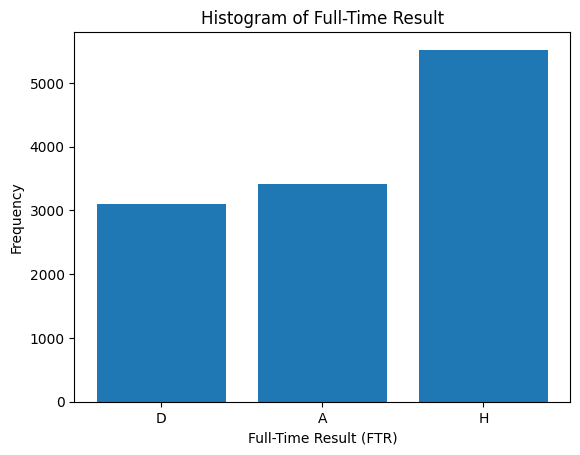

In [8]:
import matplotlib.pyplot as plt

ftr_counts = df.groupBy("FTR").count()
ftr_values = ftr_counts.select("FTR").rdd.flatMap(lambda x: x).collect()
ftr_counts = ftr_counts.select("count").rdd.flatMap(lambda x: x).collect()

plt.bar(ftr_values, ftr_counts)
plt.xlabel("Full-Time Result (FTR)")
plt.ylabel("Frequency")
plt.title("Histogram of Full-Time Result")
plt.show()

# Section 2: Clean the data

10 points

Not every dataset is going to be ready to use right away. Take steps to fix incorrect inputs, remove null values, and assign datatypes that fit each feature.

### This section should include one or more of the following:
- A count of rows before and after dropping data with null or incorrect values, including an explaination of why removing the rows was necessary in [markdown](https://www.markdownguide.org/cheat-sheet).
- Renaming a column, adding a new one, or casting an existing one as a different datatype.
- Remove punctuation marks, symbols, etc from the data, and convert all upper-case lettering to lower-case.
- Remove or fix rows that have bad values/data.

## Check for missing elements and drop un-needed columns

**There are no missing elements in the dataset.**

In [9]:
print(df.count())
df = df.dropna()
print(df.count())

12026
12026


**The week and date columns are not important for our analysis so we can drop them, and we are joining a dataset of season standings but that data is only from the season ending 2001 on**

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, when

df = df.drop('Wk','Date')
df = df.filter(df["Season_End_Year"] >= 2002)
df.show(truncate=False)

+---------------+--------------+---------+---------+--------------+---+
|Season_End_Year|Home          |HomeGoals|AwayGoals|Away          |FTR|
+---------------+--------------+---------+---------+--------------+---+
|2002           |Middlesbrough |0        |4        |Arsenal       |A  |
|2002           |Liverpool     |2        |1        |West Ham      |H  |
|2002           |Charlton Ath  |1        |2        |Everton       |A  |
|2002           |Leicester City|0        |5        |Bolton        |A  |
|2002           |Leeds United  |2        |0        |Southampton   |H  |
|2002           |Sunderland    |1        |0        |Ipswich Town  |H  |
|2002           |Derby County  |2        |1        |Blackburn     |H  |
|2002           |Tottenham     |0        |0        |Aston Villa   |D  |
|2002           |Manchester Utd|3        |2        |Fulham        |H  |
|2002           |Chelsea       |1        |1        |Newcastle Utd |D  |
|2002           |Everton       |1        |1        |Tottenham   

# Section 3: Transform the clean data

10 points

Once you have clean data, start to prepare it to fit your analysis tools. This might mean using custom code to normalize certain values, joining supplemental datasets, and/or preparing it for machine learning.

### This section should include one or more of the following:
- Write a UDF to perform a function, then use it to add a new column to your data. Explain why in [markdown](https://www.markdownguide.org/cheat-sheet)
- Join an outside data source. (It can be one you've prepared alongside the primary source you're using, as long as you link it)
- Split the data into train/test sets
- Create vectors for relavent features
- One-hot encode catagorical variables

**The UDF here is just to make the full time result more desciptive to check our model later**

In [11]:
ftr_types = {'A': 'AwayWin','H': 'HomeWin','D': 'Draw'}
broadcast = spark.sparkContext.broadcast(ftr_types)
def get_ftr(ftr):
  mapping = broadcast.value
  return mapping.get(ftr)
ftr_udf = udf(get_ftr, StringType())
new_df = df.withColumn("Full Time Result", ftr_udf(col("FTR")))
new_df = new_df.drop('FTR')
new_df.show(truncate=False)

+---------------+--------------+---------+---------+--------------+----------------+
|Season_End_Year|Home          |HomeGoals|AwayGoals|Away          |Full Time Result|
+---------------+--------------+---------+---------+--------------+----------------+
|2002           |Middlesbrough |0        |4        |Arsenal       |AwayWin         |
|2002           |Liverpool     |2        |1        |West Ham      |HomeWin         |
|2002           |Charlton Ath  |1        |2        |Everton       |AwayWin         |
|2002           |Leicester City|0        |5        |Bolton        |AwayWin         |
|2002           |Leeds United  |2        |0        |Southampton   |HomeWin         |
|2002           |Sunderland    |1        |0        |Ipswich Town  |HomeWin         |
|2002           |Derby County  |2        |1        |Blackburn     |HomeWin         |
|2002           |Tottenham     |0        |0        |Aston Villa   |Draw            |
|2002           |Manchester Utd|3        |2        |Fulham       

## Add number of points per season and average home/away goals scored for our feature set

In [12]:
from pyspark.sql import functions as F
from pyspark.sql import Window

df_with_points = new_df.withColumn("Home Points", when(col("Full Time Result") == "HomeWin", 3).when(col("Full Time Result") == "AwayWin", 0).when(col("Full Time Result") == "Draw", 1))
df_with_points = df_with_points.withColumn("Away Points", when(col("Full Time Result") == "HomeWin", 0).when(col("Full Time Result") == "AwayWin", 3).when(col("Full Time Result") == "Draw", 1))

df_with_points.show()

+---------------+--------------+---------+---------+--------------+----------------+-----------+-----------+
|Season_End_Year|          Home|HomeGoals|AwayGoals|          Away|Full Time Result|Home Points|Away Points|
+---------------+--------------+---------+---------+--------------+----------------+-----------+-----------+
|           2002| Middlesbrough|        0|        4|       Arsenal|         AwayWin|          0|          3|
|           2002|     Liverpool|        2|        1|      West Ham|         HomeWin|          3|          0|
|           2002|  Charlton Ath|        1|        2|       Everton|         AwayWin|          0|          3|
|           2002|Leicester City|        0|        5|        Bolton|         AwayWin|          0|          3|
|           2002|  Leeds United|        2|        0|   Southampton|         HomeWin|          3|          0|
|           2002|    Sunderland|        1|        0|  Ipswich Town|         HomeWin|          3|          0|
|           2002|  

## Get second kaggle dataset with team rankings each season to join that data

In [13]:
od.download(
    "https://www.kaggle.com/datasets/quadeer15sh/premier-league-standings-11-seasons-20102021")
location = './premier-league-standings-11-seasons-20102021/EPL Standings 2000-2022.csv'
second_df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(location)
second_df.show(truncate=False)
second_df.printSchema

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: caitlindunne
Your Kaggle Key: ··········


100%|██████████| 6.98k/6.98k [00:00<00:00, 4.79MB/s]

+-------+---+-----------------+---+---+---+---+---+---+---+---+----------------------------------------------------------------+
|Season |Pos|Team             |Pld|W  |D  |L  |GF |GA |GD |Pts|Qualification or relegation                                     |
+-------+---+-----------------+---+---+---+---+---+---+---+---+----------------------------------------------------------------+
|2000-01|1  |Manchester United|38 |24 |8  |6  |79 |31 |48 |80 |Qualification for the Champions League first group stage        |
|2000-01|2  |Arsenal          |38 |20 |10 |8  |63 |38 |25 |70 |Qualification for the Champions League first group stage        |
|2000-01|3  |Liverpool        |38 |20 |9  |9  |71 |39 |32 |69 |Qualification for the Champions League third qualifying round[a]|
|2000-01|4  |Leeds United     |38 |20 |8  |10 |64 |43 |21 |68 |Qualification for the UEFA Cup first round[a]                   |
|2000-01|5  |Ipswich Town     |38 |20 |6  |12 |57 |42 |15 |66 |Qualification for the UEFA Cup fir

<bound method DataFrame.printSchema of DataFrame[Season: string, Pos: int, Team: string, Pld: int, W: int, D: int, L: int, GF: int, GA: int, GD: int, Pts: int, Qualification or relegation: string]>

In [14]:
from pyspark.sql.functions import expr
from pyspark.sql.functions import concat, lit

second_df = second_df.withColumn("Season", expr("SUBSTR(Season, 6)"))
second_df = second_df.withColumn("Season", concat(lit("20"), second_df["Season"]).cast("int"))
second_df = second_df.select(["Pos", "Team", "Season", "W"])
second_df.show(40)

+---+-----------------+------+---+
|Pos|             Team|Season|  W|
+---+-----------------+------+---+
|  1|Manchester United|  2001| 24|
|  2|          Arsenal|  2001| 20|
|  3|        Liverpool|  2001| 20|
|  4|     Leeds United|  2001| 20|
|  5|     Ipswich Town|  2001| 20|
|  6|          Chelsea|  2001| 17|
|  7|       Sunderland|  2001| 15|
|  8|      Aston Villa|  2001| 13|
|  9|Charlton Athletic|  2001| 14|
| 10|      Southampton|  2001| 14|
| 11| Newcastle United|  2001| 14|
| 12|Tottenham Hotspur|  2001| 13|
| 13|   Leicester City|  2001| 14|
| 14|    Middlesbrough|  2001|  9|
| 15|  West Ham United|  2001| 10|
| 16|          Everton|  2001| 11|
| 17|     Derby County|  2001| 10|
| 18|  Manchester City|  2001|  8|
| 19|    Coventry City|  2001|  8|
| 20|    Bradford City|  2001|  5|
|  1|          Arsenal|  2002| 26|
|  2|        Liverpool|  2002| 24|
|  3|Manchester United|  2002| 24|
|  4| Newcastle United|  2002| 21|
|  5|     Leeds United|  2002| 18|
|  6|          Chels

**HomePos and AwayPos are the previous season positions of the home and away teams respectively**

In [15]:
home_join_conditions = (new_df["Season_End_Year"] == (second_df["Season"]-1)) & (new_df["Home"] == second_df["Team"])
away_join_conditions = (new_df["Season_End_Year"] == (second_df["Season"]-1)) & (new_df["Away"] == second_df["Team"])
final_df = new_df.join(second_df, home_join_conditions,"inner")
final_df = final_df.withColumnRenamed("Pos", "HomePos")
final_df = final_df.withColumnRenamed("W", "HomeW")
final_df = final_df.drop("Team", "Season")
final_df = final_df.join(second_df, away_join_conditions, how="inner")
final_df = final_df.withColumnRenamed("Pos", "AwayPos")
final_df = final_df.withColumnRenamed("W", "AwayW")
final_df = final_df.drop("Team", "Season")
final_df.show(5)

+---------------+-------------+---------+---------+-------------+----------------+-------+-----+-------+-----+
|Season_End_Year|         Home|HomeGoals|AwayGoals|         Away|Full Time Result|HomePos|HomeW|AwayPos|AwayW|
+---------------+-------------+---------+---------+-------------+----------------+-------+-----+-------+-----+
|           2002|Middlesbrough|        0|        4|      Arsenal|         AwayWin|     11|   13|      2|   23|
|           2002| Leeds United|        2|        0|  Southampton|         HomeWin|     15|   14|      8|   13|
|           2002|      Arsenal|        1|        2| Leeds United|         AwayWin|      2|   23|     15|   14|
|           2002|       Fulham|        2|        0|   Sunderland|         HomeWin|     14|   13|     20|    4|
|           2002|      Everton|        2|        0|Middlesbrough|         HomeWin|      7|   17|     11|   13|
+---------------+-------------+---------+---------+-------------+----------------+-------+-----+-------+-----+
o

**Checking again for NA since we've now joined and filtered dataframes**

In [16]:
print(final_df.count())
final_df = final_df.dropna()
print(final_df.count())

2302
2302


## Create Model and test Accuracy

**The features we're using here are final position of the teams in the previous season, and number of games won by both home and away teams the previous season**

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Full Time Result", outputCol="FTR_Index")
indexed_df = indexer.fit(final_df).transform(final_df)

feature_cols = ["HomePos", "AwayPos", "HomeW", "AwayW"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(indexed_df)

# Select the features and the target variable ('Full Time Result')
data = data.select("features", "FTR_Index")
data.show()
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2])

lr = LogisticRegression(featuresCol="features", labelCol="FTR_Index")

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make predictions on the testing data
predictions = lr_model.transform(test_data)
prediction_rdd = predictions.select("prediction", "FTR_Index").rdd.map(tuple)

metrics = MulticlassMetrics(prediction_rdd)
print("Test model accuracy: ", metrics.accuracy)


+--------------------+---------+
|            features|FTR_Index|
+--------------------+---------+
|[11.0,2.0,13.0,23.0]|      1.0|
|[15.0,8.0,14.0,13.0]|      0.0|
|[2.0,15.0,23.0,14.0]|      1.0|
|[14.0,20.0,13.0,4.0]|      0.0|
|[7.0,11.0,17.0,13.0]|      0.0|
| [8.0,4.0,13.0,19.0]|      1.0|
|[5.0,16.0,18.0,12.0]|      1.0|
| [4.0,2.0,19.0,23.0]|      2.0|
|[14.0,2.0,13.0,23.0]|      1.0|
| [7.0,5.0,17.0,18.0]|      1.0|
|[16.0,20.0,12.0,4.0]|      2.0|
|[4.0,11.0,19.0,13.0]|      2.0|
|[8.0,16.0,13.0,12.0]|      1.0|
|[11.0,8.0,13.0,13.0]|      1.0|
|[14.0,4.0,13.0,19.0]|      2.0|
| [8.0,2.0,13.0,23.0]|      1.0|
|[5.0,15.0,18.0,14.0]|      2.0|
|[16.0,14.0,12.0,1...|      0.0|
|[7.0,16.0,17.0,12.0]|      0.0|
|[15.0,4.0,14.0,19.0]|      2.0|
+--------------------+---------+
only showing top 20 rows

Test model accuracy:  0.504524886877828


# Section 4: Show your analysis of the data

10 points

This is where the science happens. Use your data to show some kind of insight, and how you got there. Make the reader understand why it's important, and how they can get the same conslusion, and/or what would need to change to reach a different one.

### This section should include one or more of the following:
- Fit the data to a model
- Show the outcome of clustering, regression, and/or classification algorithms.
 - We used several in class, but you can use whatever fits your needs for this assignment
- Reccomend a product/item
- Use a SQL query to filter results


## Creating dataset for upcoming matches

In [18]:
liverpool_at_wolverhampton = {"HomePos":13, "AwayPos":5, "HomeW":11, "AwayW":19} #wolverhampton 2022 standing, liverpool 2022 standing, wolverhampton games won 2022, liverpool games won 2022
crystal_palace_at_aston_villa = {"HomePos":7, "AwayPos":11, "HomeW":18, "AwayW":11}
luton_town_at_fulham = {"HomePos":10, "AwayPos":21, "HomeW":15, "AwayW":0} #Luton Town wasn't in the premier league last season so I'm saying they placed 21st out of 20 teams
man_city_at_west_ham = {"HomePos":14, "AwayPos":1, "HomeW":11, "AwayW":28}
brighton_at_man_united = {"HomePos":3, "AwayPos":6, "HomeW":23, "AwayW": 18}
arsenal_at_everton = {"HomePos":17, "AwayPos":2, "HomeW":8, "AwayW":26}

upcoming_df = spark.createDataFrame([liverpool_at_wolverhampton, crystal_palace_at_aston_villa, luton_town_at_fulham, man_city_at_west_ham, brighton_at_man_united, arsenal_at_everton])
upcoming_df.show()
feature_cols = ["HomePos", "AwayPos", "HomeW", "AwayW"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(upcoming_df)
data = data.select("features")

/content/spark-3.0.1-bin-hadoop2.7/python/pyspark/sql/session.py:381: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-------+-----+-------+-----+
|AwayPos|AwayW|HomePos|HomeW|
+-------+-----+-------+-----+
|      5|   19|     13|   11|
|     11|   11|      7|   18|
|     21|    0|     10|   15|
|      1|   28|     14|   11|
|      6|   18|      3|   23|
|      2|   26|     17|    8|
+-------+-----+-------+-----+



## Running prediction on upcoming fixtures

In [19]:
predictions = lr_model.transform(data)
upcoming_prediction_rdd = predictions.select("prediction").rdd.map(tuple)
print(upcoming_prediction_rdd.take(6))

[(1.0,), (0.0,), (0.0,), (1.0,), (0.0,), (1.0,)]


**According to my model Liverpool, Aston Villa, Fulham, Man City, Man United and Everton will win their games.**

## Trying another model just for fun

In [20]:
from pyspark.ml.classification import RandomForestClassifier

data = assembler.transform(indexed_df)

# Select the features and the target variable ('Full Time Result')
data = data.select("features", "FTR_Index")
data.show()
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2])

rf = RandomForestClassifier(featuresCol='features', labelCol='FTR_Index')
rfModel = rf.fit(train_data)

# Make predictions on the testing data
predictions = rfModel.transform(test_data)
prediction_rdd = predictions.select("prediction", "FTR_Index").rdd.map(tuple)

metrics = MulticlassMetrics(prediction_rdd)
print("Test model accuracy: ", metrics.accuracy)

+--------------------+---------+
|            features|FTR_Index|
+--------------------+---------+
|[11.0,2.0,13.0,23.0]|      1.0|
|[15.0,8.0,14.0,13.0]|      0.0|
|[2.0,15.0,23.0,14.0]|      1.0|
|[14.0,20.0,13.0,4.0]|      0.0|
|[7.0,11.0,17.0,13.0]|      0.0|
| [8.0,4.0,13.0,19.0]|      1.0|
|[5.0,16.0,18.0,12.0]|      1.0|
| [4.0,2.0,19.0,23.0]|      2.0|
|[14.0,2.0,13.0,23.0]|      1.0|
| [7.0,5.0,17.0,18.0]|      1.0|
|[16.0,20.0,12.0,4.0]|      2.0|
|[4.0,11.0,19.0,13.0]|      2.0|
|[8.0,16.0,13.0,12.0]|      1.0|
|[11.0,8.0,13.0,13.0]|      1.0|
|[14.0,4.0,13.0,19.0]|      2.0|
| [8.0,2.0,13.0,23.0]|      1.0|
|[5.0,15.0,18.0,14.0]|      2.0|
|[16.0,14.0,12.0,1...|      0.0|
|[7.0,16.0,17.0,12.0]|      0.0|
|[15.0,4.0,14.0,19.0]|      2.0|
+--------------------+---------+
only showing top 20 rows

Test model accuracy:  0.4956521739130435


**This model is ~1% more accurate, so I don't think it's worth re-running the upcoming matches thru.**

## Future Improvements

**Since the model is only ~50% accurate there's clearly room for improvement.  We also weren't able to showcase home field advantage which we saw was an important feature.  This could be accomplished by computing previous season home wins vs total wins.  Also we know there are lots of factors that contribute to Premier League success like $ spent on transfers, individual player performance, managerial stats, winnig streak, etc. So the best models will take these factors into account with a much more comprehensive dataset.**